### Import Packages

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime
import os
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Read file and data preprocess

In [2]:
regression_model_input_O = pd.read_csv('Data/Jacksonville/regression_model_input_O_new.csv')
regression_model_input_O.head()

,cluster,Start Latitude,Start Longitude,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
0,0,30.325581,-81.655385,3056,POINT (-81.65538482745099 30.325580785620915),0.0,0.0,0.0,4.0,8.0,...,0.008865,0.059939,0.005456,0.0,0.012106,0.000000,0.0,0.0,0.0,0.001847
1,1,30.327773,-81.661543,1406,POINT (-81.66154306818181 30.327772919421488),0.0,0.0,0.0,1.0,2.0,...,0.004450,0.067959,0.017838,0.0,0.029983,0.005722,0.0,0.0,0.0,0.000939
2,2,30.328892,-81.658779,1120,POINT (-81.6587786375 30.32889174375),0.0,2.0,0.0,1.0,4.0,...,0.001246,0.064573,0.019775,0.0,0.022735,0.000000,0.0,0.0,0.0,0.000000
3,3,30.325285,-81.661160,1028,POINT (-81.66115992898833 30.32528520330739),0.0,2.0,0.0,2.0,0.0,...,0.031118,0.073101,0.005203,0.0,0.003009,0.000000,0.0,0.0,0.0,0.000000
4,4,30.323735,-81.655858,993,POINT (-81.65585779744765 30.323734838023558),0.0,0.0,0.0,0.0,0.0,...,0.016444,0.078774,0.005182,0.0,0.073617,0.000000,0.0,0.0,0.0,0.007140


In [3]:
regression_model_input_O.columns

Index(['cluster', 'Start Latitude', 'Start Longitude', 'ridership', 'geometry',
       'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'GEOID', 'MED_AGE', 'AVE_HH_SZ',
       'HS_PER_AC', 'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity',
       'Den_Bike_Lane', 'Den_Transit_Route', 'Den_Road_Network', 'school',
       'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain',
       'pub', 'theatre', 'library', 'shelter', 'ferry_terminal', 'clinic',
       'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station',
       'pct_road', 'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence',
       'pct_pole', 'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       

### Data Ready for regression models

#### remove some variables and rename some variables

In [4]:
# O_clusters
regression_model_input_O_final = regression_model_input_O.copy()
regression_model_input_O_final = regression_model_input_O_final.drop(columns = {'cluster', 'geometry', 'GEOID'})
regression_model_input_O_final['ridership'] = regression_model_input_O_final['ridership']/125 # rides per day
regression_model_input_O_final['PCT_WHITE'] = regression_model_input_O_final['PCT_WHITE']/100 # PCT_WHITE
POI_list = ['school', 'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'clinic', 'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station', 'ferry_terminal']
dist_POI_list = ['dist_from_school', 'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant', 'dist_from_bank', 
                 'dist_from_parking', 'dist_from_cafe', 'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
                 'dist_from_library', 'dist_from_shelter', 'dist_from_clinic', 'dist_from_bus_station', 
                 'dist_from_bicycle_parking', 'dist_from_hospital', 'dist_from_bicycle_repair_station', 'dist_from_ferry_terminal']
for i in range (len(POI_list)):
    regression_model_input_O_final = regression_model_input_O_final.rename(columns = {POI_list[i]:dist_POI_list[i]})
    regression_model_input_O_final[dist_POI_list[i]] = regression_model_input_O_final[dist_POI_list[i]]/1600
pct_list = ['pct_road', 'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole', 'pct_traffic_light', 
            'pct_traffic_sign', 'pct_vegetation', 'pct_terrain', 'pct_sky', 'pct_person', 'pct_rider', 'pct_car',
            'pct_truck', 'pct_bus', 'pct_train', 'pct_motorcycle', 'pct_bicycle']
SVI_pct_list = ['SVI_pct_road', 'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole', 
                'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation', 'SVI_pct_terrain', 'SVI_pct_sky', 
                'SVI_pct_person', 'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 
                'SVI_pct_motorcycle', 'SVI_pct_bicycle']
for i in range (len(pct_list)):
    regression_model_input_O_final = regression_model_input_O_final.rename(columns = {pct_list[i]:SVI_pct_list[i]})
regression_model_input_O_final.head()

,Start Latitude,Start Longitude,ridership,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,...,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
0,30.325581,-81.655385,24.448,0.0,0.0,0.0,4.0,8.0,0.0,18.0,...,0.008865,0.059939,0.005456,0.0,0.012106,0.000000,0.0,0.0,0.0,0.001847
1,30.327773,-81.661543,11.248,0.0,0.0,0.0,1.0,2.0,0.0,13.0,...,0.004450,0.067959,0.017838,0.0,0.029983,0.005722,0.0,0.0,0.0,0.000939
2,30.328892,-81.658779,8.960,0.0,2.0,0.0,1.0,4.0,0.0,14.0,...,0.001246,0.064573,0.019775,0.0,0.022735,0.000000,0.0,0.0,0.0,0.000000
3,30.325285,-81.661160,8.224,0.0,2.0,0.0,2.0,0.0,0.0,8.0,...,0.031118,0.073101,0.005203,0.0,0.003009,0.000000,0.0,0.0,0.0,0.000000
4,30.323735,-81.655858,7.944,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.016444,0.078774,0.005182,0.0,0.073617,0.000000,0.0,0.0,0.0,0.007140


#### Show columns

In [5]:
regression_model_input_O_final.columns

Index(['Start Latitude', 'Start Longitude', 'ridership', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_bank', 'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
       'dist_from_library', 'dist_from_shelter', 'dist_from_ferry_terminal',
       'dist_from_clinic', 'dist_from_bus_station',
       'dist_from_bicycle_parking', 'dist_from_hospital',
       'dist_from_bicycle_re

#### descriptive statistics

#### O_cluster

In [6]:
# ridership
regression_model_input_O_final['ridership'].describe()

count    83.000000
mean      2.576289
std       3.733554
min       0.008000
25%       0.264000
50%       1.096000
75%       3.420000
max      24.448000
Name: ridership, dtype: float64

In [7]:
# No. of POI within a 250-m cluster buffer
regression_model_input_O_final[['other_num_buff250', 'residential_num_buff250',
       'education_num_buff250', 'cultural_num_buff250',
       'recreational_num_buff250', 'social_num_buff250',
       'transportation_num_buff250', 'commercial_num_buff250',
       'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250']].describe()

,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.156627,0.301205,0.265060,0.722892,2.048193,0.481928,14.445783,4.397590,0.277108,0.469880,0.240964,0.228916
std,0.365658,0.619499,0.470711,1.140317,3.184963,1.525087,6.637390,5.723166,0.686334,0.915148,0.918514,0.525573
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15.000000,3.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.500000,1.000000,3.000000,0.000000,18.000000,6.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,2.000000,2.000000,4.000000,19.000000,9.000000,39.000000,25.000000,3.000000,4.000000,7.000000,2.000000


In [8]:
# census tract socio-demographics & built environment
regression_model_input_O_final[['MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network']].describe()

,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,41.553012,1.538916,2.462771,0.473665,5.985783,0.527284,1.609345,0.008617,4.420791,0.089462
std,4.149503,0.319031,1.315296,0.196296,8.893260,0.084031,0.133730,0.018466,3.388038,0.065722
min,35.200000,1.330000,0.370000,0.121600,0.750000,0.479118,1.445889,0.000000,0.399217,0.014643
25%,40.300000,1.370000,1.300000,0.383500,2.095000,0.496097,1.445889,0.001742,0.824953,0.033568
50%,41.600000,1.390000,2.720000,0.456400,3.330000,0.496097,1.640601,0.002979,4.509078,0.096148
75%,41.600000,1.560000,2.720000,0.713400,3.330000,0.503360,1.733053,0.003268,6.393644,0.096148
max,51.000000,2.430000,4.870000,0.730900,29.730000,0.752383,1.793239,0.061114,10.574427,0.241302


In [9]:
# Distance to POI
regression_model_input_O_final[dist_POI_list].describe()

,dist_from_school,dist_from_bar,dist_from_fast_food,dist_from_restaurant,dist_from_bank,dist_from_parking,dist_from_cafe,dist_from_fountain,dist_from_pub,dist_from_theatre,dist_from_library,dist_from_shelter,dist_from_clinic,dist_from_bus_station,dist_from_bicycle_parking,dist_from_hospital,dist_from_bicycle_repair_station,dist_from_ferry_terminal
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.371750,0.262974,0.369108,0.193371,0.289123,0.093286,0.461907,0.330418,0.424284,0.324356,0.631526,0.518057,0.888004,0.823773,0.585209,0.822168,1.234958,0.593326
std,0.254090,0.192824,0.324609,0.125022,0.285893,0.014588,0.384414,0.205733,0.262148,0.210134,0.422823,0.331787,0.367499,0.341267,0.370041,0.341140,0.425202,0.280102
min,0.017151,0.007774,0.042786,0.056645,0.030871,0.041352,0.027944,0.043563,0.040597,0.037929,0.007219,0.060392,0.071635,0.043823,0.061607,0.048370,0.468783,0.118913
25%,0.183218,0.133948,0.156074,0.098125,0.108708,0.083370,0.157933,0.178564,0.206038,0.157082,0.254063,0.314703,0.691413,0.599058,0.304882,0.647658,0.889466,0.391501
50%,0.300638,0.198260,0.254550,0.143419,0.167616,0.094804,0.366414,0.295263,0.361171,0.294231,0.559450,0.426508,0.924857,0.844173,0.526825,0.845648,1.138948,0.558404
75%,0.489533,0.348465,0.478564,0.257188,0.335145,0.103183,0.648768,0.461981,0.612918,0.434006,0.948786,0.657706,1.136643,1.090697,0.795041,1.015419,1.613193,0.780516
max,1.137144,0.784195,1.664993,0.555601,1.526278,0.131613,1.664919,0.791400,1.080888,0.878443,1.780739,1.799917,1.566816,1.370203,1.792844,1.887456,2.348315,1.343124


In [10]:
# Ratio of objects in SVIs
regression_model_input_O_final[SVI_pct_list].describe()

,SVI_pct_road,SVI_pct_sidewalk,SVI_pct_building,SVI_pct_wall,SVI_pct_fence,SVI_pct_pole,SVI_pct_traffic_light,SVI_pct_traffic_sign,SVI_pct_vegetation,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.0,83.000000,83.000000
mean,0.306686,0.042521,0.262450,0.007229,0.014560,0.006877,0.000344,0.003821,0.152736,0.034109,0.132739,0.007396,0.000078,0.022930,0.003468,0.000109,0.0,0.000730,0.001218
std,0.055701,0.036083,0.128322,0.017050,0.024976,0.004600,0.000660,0.010553,0.101446,0.040891,0.082240,0.007651,0.000345,0.024652,0.017683,0.000395,0.0,0.004045,0.003433
min,0.169296,0.000000,0.018333,0.000000,0.000000,0.000325,0.000000,0.000000,0.003629,0.000000,0.025590,0.000218,0.000000,0.000110,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.273608,0.017685,0.155482,0.000005,0.001879,0.003573,0.000000,0.000258,0.078569,0.007283,0.077386,0.002147,0.000000,0.007022,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.309902,0.032402,0.269242,0.000803,0.006192,0.005600,0.000128,0.000924,0.127469,0.023735,0.102147,0.005182,0.000000,0.013687,0.000000,0.000000,0.0,0.000000,0.000007
75%,0.337694,0.058389,0.339664,0.006367,0.014820,0.009495,0.000430,0.002654,0.186599,0.039972,0.171101,0.009263,0.000000,0.032448,0.000108,0.000000,0.0,0.000000,0.000879
max,0.423573,0.130229,0.580463,0.094132,0.189999,0.020556,0.003861,0.069012,0.542356,0.227432,0.381194,0.042141,0.002508,0.118077,0.128683,0.002362,0.0,0.035960,0.027189


### Data preparation

#### Variance threshold: remove <0.001

In [11]:
len(regression_model_input_O_final.columns)

62

In [12]:
##  'SVI_pct_traffic_light', 'SVI_pct_rider',  'SVI_pct_bus', 'SVI_pct_train',

#### calculate correlation coefficient: remove > 0.7

In [13]:
# O_clusters

var_list = np.array(['Start Latitude', 'Start Longitude', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_bank', 'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
       'dist_from_library', 'dist_from_shelter', 'dist_from_ferry_terminal',
       'dist_from_clinic', 'dist_from_bus_station',
       'dist_from_bicycle_parking', 'dist_from_hospital',
       'dist_from_bicycle_repair_station', 'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person',
       'SVI_pct_car', 'SVI_pct_truck',
       'SVI_pct_motorcycle', 'SVI_pct_bicycle'])

data = regression_model_input_O_final[var_list]

# Calculate correlation matrix
correlation_matrix = data.corr()

# Print correlation matrix
print("Correlation Matrix:")

# find highly correlated feature groups
for i in range(len(np.where(correlation_matrix > 0.7)[0])):
    h_index = np.where(correlation_matrix > 0.7)[0][i]
    v_index = np.where(correlation_matrix > 0.7)[1][i]
    if h_index < v_index:
        print(var_list[h_index], "=======", var_list[v_index], correlation_matrix.iloc[h_index, v_index])

Correlation Matrix:
Start Longitude ======= dist_from_fast_food 0.7441040416253293
Start Longitude ======= dist_from_shelter 0.742886752373366
MED_AGE ======= Den_Bike_Lane 0.7048256301200132
AVE_HH_SZ ======= dist_from_fast_food 0.7567619197317237
AVE_HH_SZ ======= dist_from_bank 0.7666975262650869
HS_PER_AC ======= DEN_POP 0.7536830745966491
HS_PER_AC ======= Den_Transit_Route 0.7040232941889901
HS_PER_AC ======= Den_Road_Network 0.7764324737425815
DEN_POP ======= PCT_MALE 0.9912384020244646
DEN_POP ======= Den_Transit_Route 0.7172585037919961
DEN_POP ======= Den_Road_Network 0.8930278345017234
PCT_MALE ======= Den_Road_Network 0.8422793968569929
LU_diversity ======= dist_from_cafe 0.7436362930377168
LU_diversity ======= dist_from_library 0.7085350310965262
Den_Transit_Route ======= Den_Road_Network 0.9221692643259982
dist_from_fast_food ======= dist_from_bank 0.9155595217349917
dist_from_fast_food ======= dist_from_shelter 0.8997379446770885
dist_from_bank ======= dist_from_shelter 

In [14]:
## HS_PER_AC, 'PCT_MALE', 'Den_Road_Network', 'Start Longitude','dist_from_shelter',  'dist_from_bicycle_repair_station', 
## 'dist_from_bicycle_parking', 'dist_from_bank', 'dist_from_clinic', 'SVI_pct_motorcycle', 'AVE_HH_SZ', 'dist_from_library', 
## 'LU_diversity', 'MED_AGE', 'dist_from_theatre',

# O_clusters

var_list = np.array(['Start Latitude',  'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 
       'PCT_WHITE', 'DEN_POP', 'Den_Bike_Lane',
       'Den_Transit_Route', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_pub', 
       'dist_from_ferry_terminal',
       'dist_from_bus_station',
       'dist_from_hospital',
       'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bicycle'])

data = regression_model_input_O_final[var_list]

# Calculate correlation matrix
correlation_matrix = data.corr()

# Print correlation matrix
print("Correlation Matrix:")

# find highly correlated feature groups
for i in range(len(np.where(correlation_matrix > 0.7)[0])):
    h_index = np.where(correlation_matrix > 0.7)[0][i]
    v_index = np.where(correlation_matrix > 0.7)[1][i]
    if h_index < v_index:
        print(var_list[h_index], "=======", var_list[v_index], correlation_matrix.iloc[h_index, v_index])

Correlation Matrix:
DEN_POP ======= Den_Transit_Route 0.7172585037919961


In [15]:
len(var_list)

42

#### Calculate multicollearity: remove > 10

##### O_clusters

In [16]:
# O_clusters (final)

var_list = np.array(['Start Latitude',  'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 
       'PCT_WHITE', 'DEN_POP', 'Den_Bike_Lane',
       'Den_Transit_Route', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_pub', 
       'dist_from_ferry_terminal',
       'dist_from_bus_station',
       'dist_from_hospital',
       'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bicycle'])

data = regression_model_input_O_final[var_list]

# Calculate VIF
X = data.values
vif = pd.DataFrame()
vif["Feature"] = data.columns
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Print VIF
print("\nVariance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
                       Feature            VIF
0               Start Latitude  408913.814963
1            other_num_buff250       6.137306
2      residential_num_buff250       3.533899
3        education_num_buff250       3.939698
4         cultural_num_buff250       6.628327
5     recreational_num_buff250       6.957229
6           social_num_buff250       7.486960
7   transportation_num_buff250      26.488346
8       commercial_num_buff250       6.877372
9       government_num_buff250       5.430823
10        religion_num_buff250       8.883371
11          health_num_buff250       3.973411
12    publicsafety_num_buff250       5.698503
13                   PCT_WHITE     301.001029
14                     DEN_POP      21.561278
15               Den_Bike_Lane      10.675817
16           Den_Transit_Route      96.140928
17            dist_from_school      81.139082
18               dist_from_bar      34.028990
19         dist_from_fast_food     184.630641


In [17]:
# 'Start Latitude',  'SVI_pct_road', 'dist_from_hospital', 'dist_from_bus_station',
# 'PCT_WHITE', 'dist_from_ferry_terminal', 'SVI_pct_building', 'dist_from_parking', 
# 'SVI_pct_sky','transportation_num_buff250','dist_from_pub', 'Den_Transit_Route',
# 'dist_from_fountain', 'dist_from_school',

# O_clusters (final)

var_list = np.array(['other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 
       'DEN_POP', 'Den_Bike_Lane',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_cafe',
       'SVI_pct_sidewalk',
       'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain',  'SVI_pct_person',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bicycle'])

data = regression_model_input_O_final[var_list]

# Calculate VIF
X = data.values
vif = pd.DataFrame()
vif["Feature"] = data.columns
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Print VIF
print("\nVariance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
                     Feature       VIF
0          other_num_buff250  3.948545
1    residential_num_buff250  2.691428
2      education_num_buff250  2.194409
3       cultural_num_buff250  3.725286
4   recreational_num_buff250  5.692213
5         social_num_buff250  4.947896
6     commercial_num_buff250  4.365420
7     government_num_buff250  2.659693
8       religion_num_buff250  2.864208
9         health_num_buff250  1.153849
10  publicsafety_num_buff250  4.168602
11                   DEN_POP  2.952124
12             Den_Bike_Lane  3.194263
13             dist_from_bar  4.652072
14       dist_from_fast_food  7.606499
15      dist_from_restaurant  7.316198
16            dist_from_cafe  6.043982
17          SVI_pct_sidewalk  3.689925
18              SVI_pct_wall  2.037112
19             SVI_pct_fence  2.411996
20              SVI_pct_pole  5.188252
21      SVI_pct_traffic_sign  2.463047
22        SVI_pct_vegetation  4.818953
23           SVI_pct_terrain  

In [18]:
len(var_list)

28

## Model building

### O_clusters

#### SHAP + XGBoost regressor + No data split

MSE: 3.4355060185034637e-07
R2: 0.9999999750534682


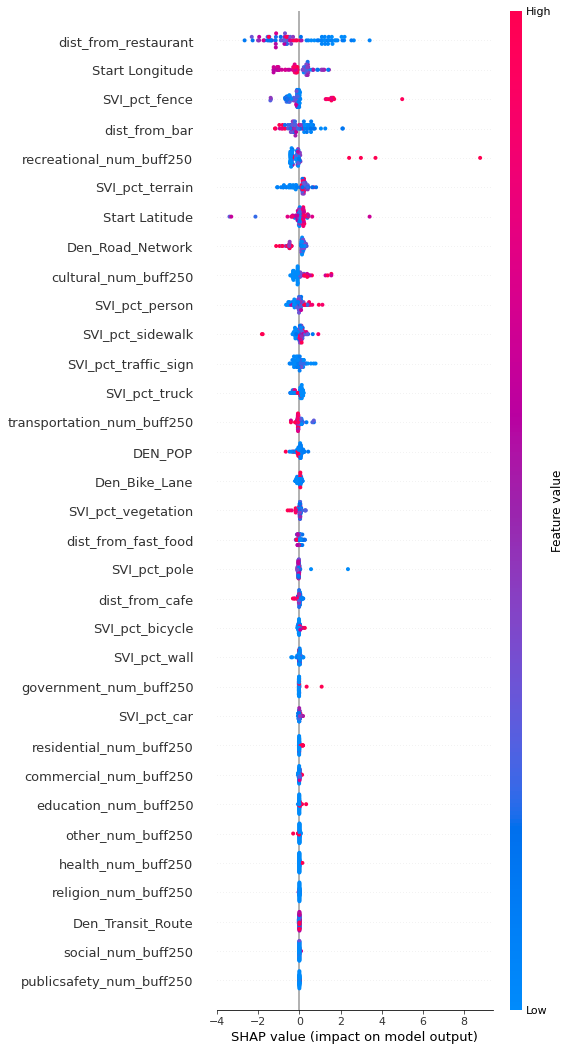

In [19]:
# Log Y
# Feature selection based on XGBoost

var_list = np.array(['DEN_POP', 'Den_Bike_Lane', 'Start Latitude', 'Start Longitude', 'Den_Transit_Route', 'Den_Road_Network', 
                     'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250', 'publicsafety_num_buff250', 'transportation_num_buff250',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant', 'dist_from_cafe',
       'SVI_pct_sidewalk', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole',
       'SVI_pct_traffic_sign', 'SVI_pct_vegetation', 'SVI_pct_terrain',  'SVI_pct_person',
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bicycle'])

y = regression_model_input_O_final['ridership']
X = regression_model_input_O_final[var_list]

xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X, y)

# Predict on the test set
y_pred = xgb_model.predict(X)
print('MSE:', mean_squared_error(y, y_pred))
print('R2:', r2_score(y, y_pred))

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(xgb_model, X)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X)

# Visualize SHAP values
shap.summary_plot(shap_values, X, max_display=X.shape[1])

##### LAT, LON, CENSUS 

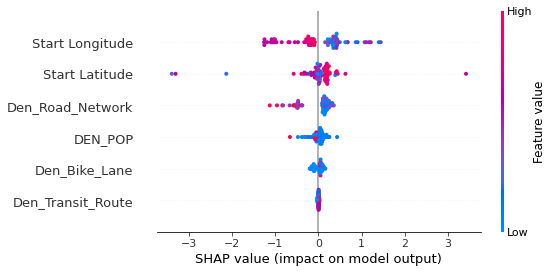

In [20]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 0:6], X.iloc[:, 0:6], max_display=X.shape[1])

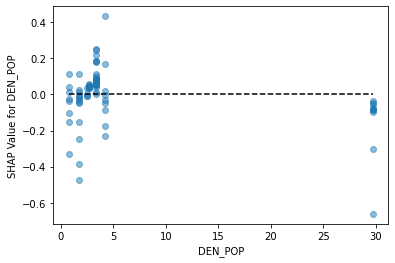

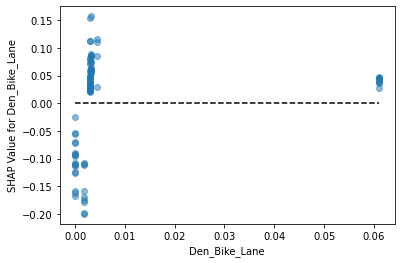

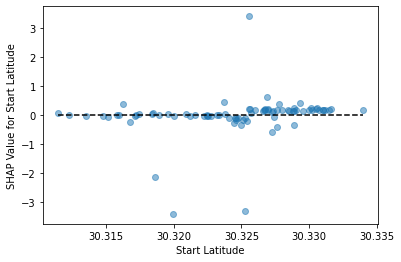

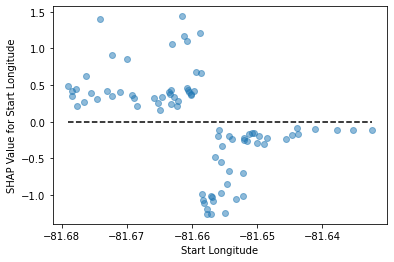

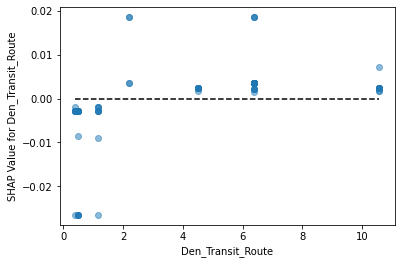

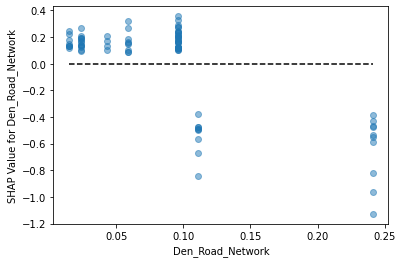

In [21]:
# Plot SHAP values of Feature 0 against the target
for i in range (6):
    feature_name = var_list[i] #
    plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

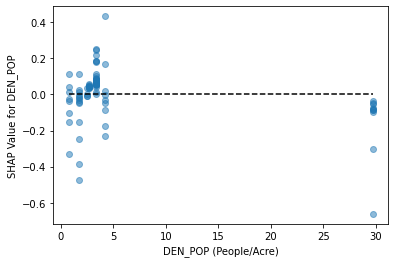

In [22]:
# Plot SHAP values of Feature 0 against the target
i = 0
feature_name = var_list[i] #
plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(People/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

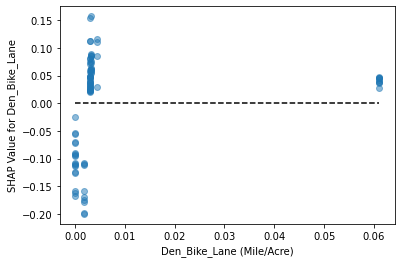

In [23]:
# Plot SHAP values of Feature 0 against the target
i = 1
feature_name = var_list[i] #
plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

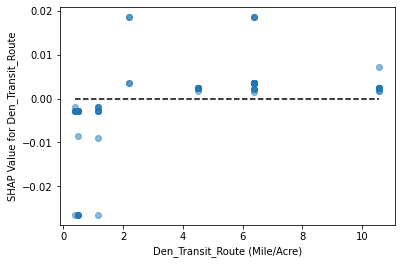

In [24]:
# Plot SHAP values of Feature 0 against the target
i = 4
feature_name = var_list[i] #
plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

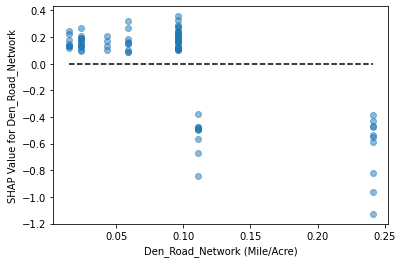

In [25]:
# Plot SHAP values of Feature 0 against the target
i = 5
feature_name = var_list[i] #
plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

### NUM POI

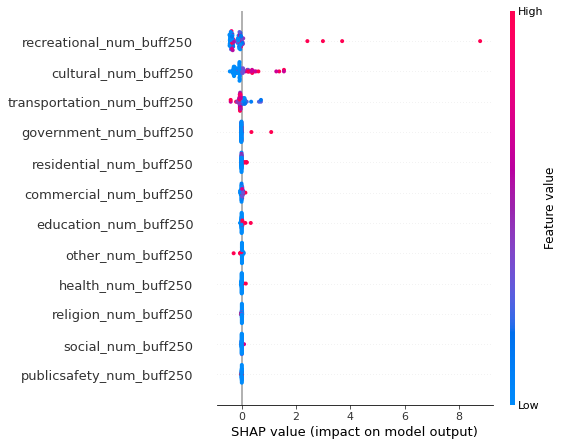

In [26]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 6:18], X.iloc[:, 6:18], max_display=X.shape[1])

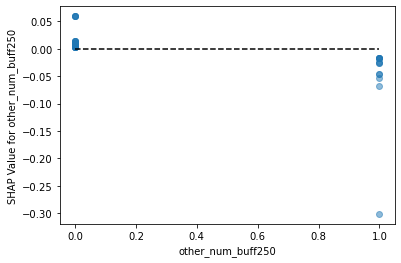

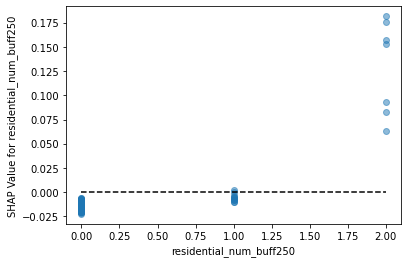

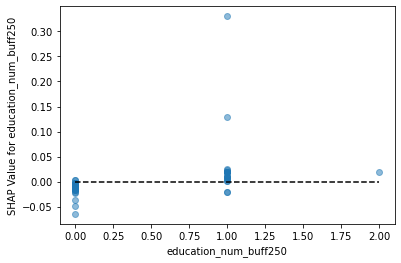

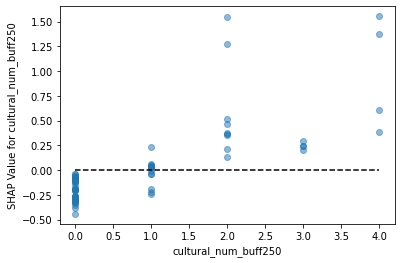

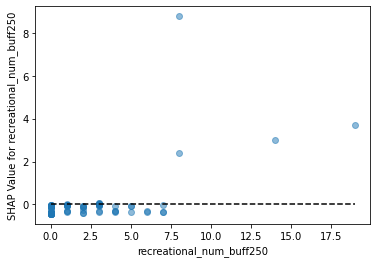

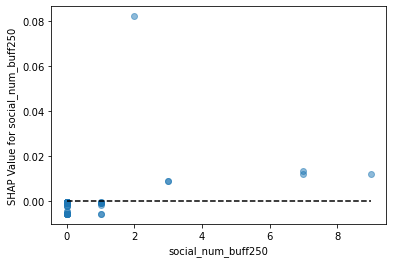

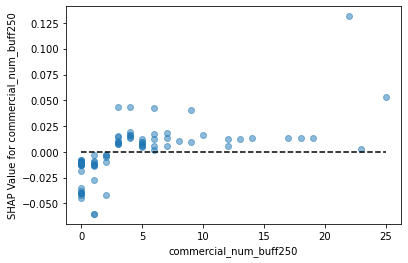

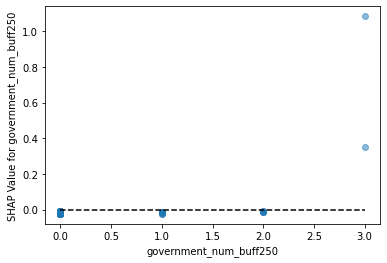

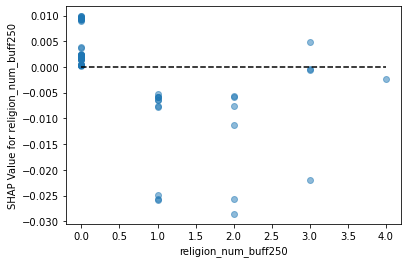

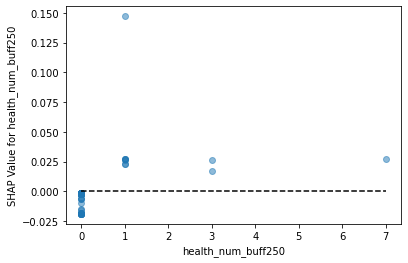

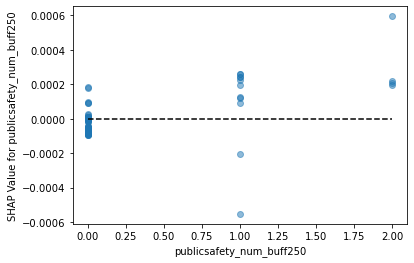

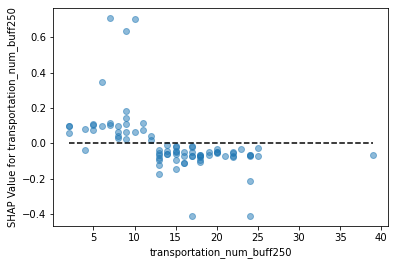

In [27]:
# Plot SHAP values of Feature 0 against the target
for i in range (6, 18):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

### DIST POI

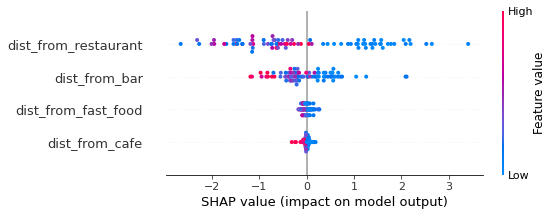

In [28]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 18:22], X.iloc[:, 18:22], max_display=X.shape[1])

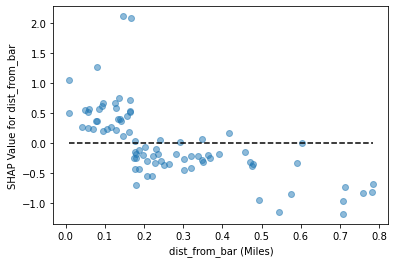

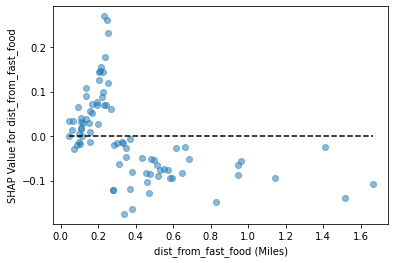

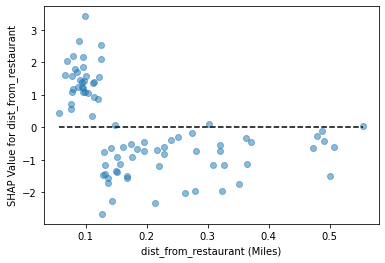

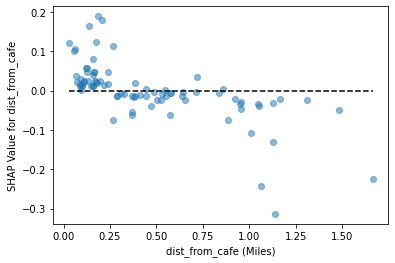

In [29]:
# Plot SHAP values of Feature 0 against the target
for i in range (18, 22):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name + ' ' + '(Miles)')
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

##### SVI

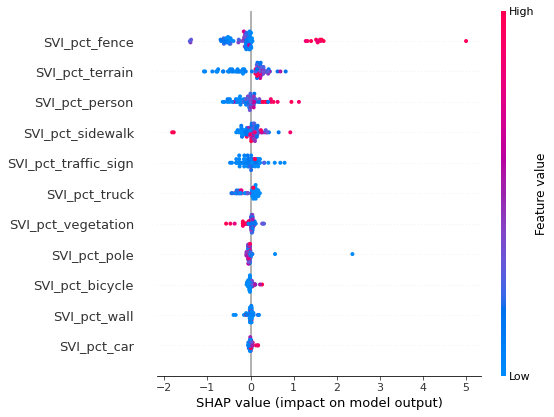

In [30]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 22:], X.iloc[:, 22:], max_display=X.shape[1])

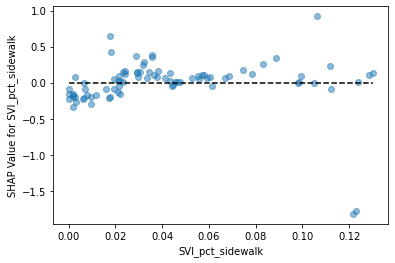

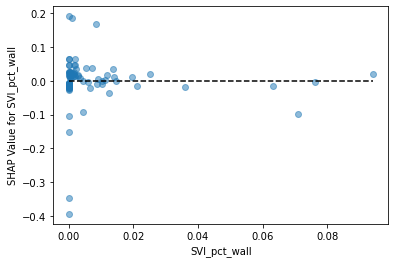

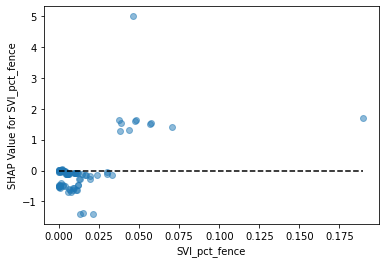

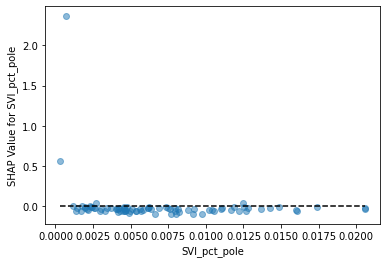

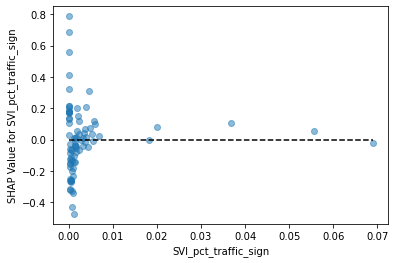

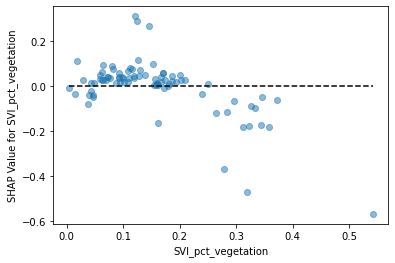

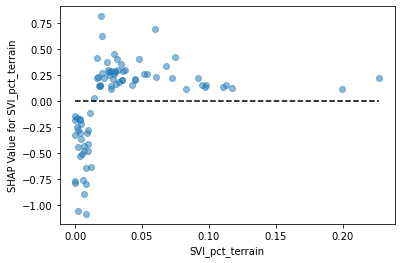

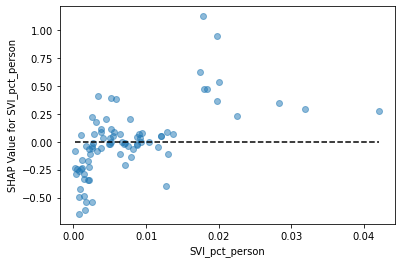

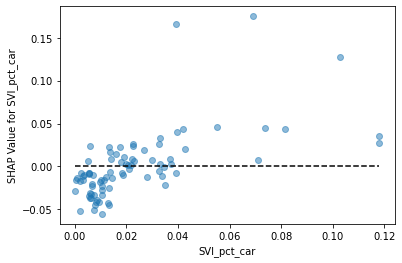

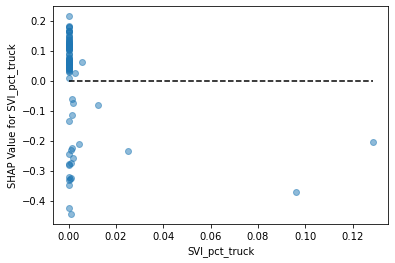

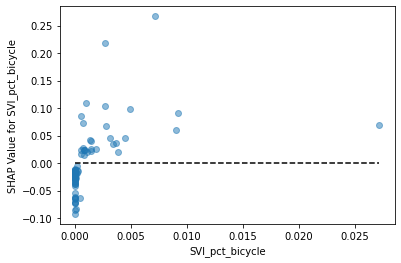

In [31]:
# Plot SHAP values of Feature 0 against the target
for i in range (22, len(var_list)):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()